In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io as sci
from sklearn.feature_extraction.image import extract_patches_2d

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import math
from itertools import permutations
import sys
sys.path.append('../')
from src.vca import vca
from scipy.linalg import norm

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [4]:
nCol = 95
nRow = 95

data_samson = sci.loadmat('../datasets/samson/samson_1.mat')
X_samson = data_samson['V']
X_samson = X_samson.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations
# X_samson = X_samson.T.reshape(-1, nCol, nRow)

gt = sci.loadmat('../datasets/samson/end3.mat')
endmembers_samson = gt['M']
abundances_samson = gt['A']

endmembers_dataset = []
for _ in range(100):
    endmembers_vca, _, _ = vca(X_samson, 3, verbose = True, snr_input = 0)
    for i in range(3):
        endmembers_vca[:, i] /= norm(endmembers_vca[:, i])
    endmembers_dataset.append(torch.Tensor(endmembers_vca.reshape(-1)))

SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.68202011238373[dB]
... Select the projective proj.
SNR estimated = 32.6

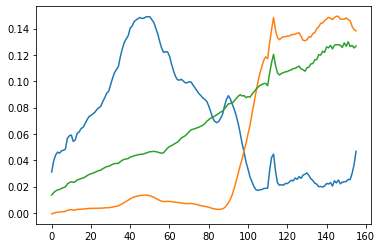

In [5]:
plt.plot(endmembers_dataset[5].reshape((156,3)))
plt.show()

In [6]:
# create train and test dataloaders
batch_size = 10
train_loader = DataLoader(dataset=endmembers_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class VAE(nn.Module):

    def __init__(self, input_dim=156*3, hidden_dim=156, latent_dim=2, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [8]:
from torch.optim import lr_scheduler

vae_model = VAE().to(device)
optimizer = Adam(vae_model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)

def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train(model, optimizer, epochs, device, x_dim=156*3):
    model.train()
    losses = []
    for epoch in range(epochs):
        overall_loss = 0
        for x in train_loader:
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        losses.append(overall_loss)
            

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss)
    return losses

In [9]:
losses = train(vae_model, optimizer, epochs=100, device=device)

	Epoch 1 	Average Loss:  2430.437600135803
	Epoch 2 	Average Loss:  170.39713096618652
	Epoch 3 	Average Loss:  211.16151809692383
	Epoch 4 	Average Loss:  183.19902896881104
	Epoch 5 	Average Loss:  124.55531311035156
	Epoch 6 	Average Loss:  78.57489252090454
	Epoch 7 	Average Loss:  54.59645748138428
	Epoch 8 	Average Loss:  37.02662134170532
	Epoch 9 	Average Loss:  29.060176610946655
	Epoch 10 	Average Loss:  23.952847719192505
	Epoch 11 	Average Loss:  22.041474223136902
	Epoch 12 	Average Loss:  20.42043524980545
	Epoch 13 	Average Loss:  20.226940035820007
	Epoch 14 	Average Loss:  20.026711583137512
	Epoch 15 	Average Loss:  19.99668562412262
	Epoch 16 	Average Loss:  19.807023286819458
	Epoch 17 	Average Loss:  19.73992955684662
	Epoch 18 	Average Loss:  19.658297419548035
	Epoch 19 	Average Loss:  19.82990062236786
	Epoch 20 	Average Loss:  19.87631642818451
	Epoch 21 	Average Loss:  19.817201495170593
	Epoch 22 	Average Loss:  19.7740957736969
	Epoch 23 	Average Loss:  19.7

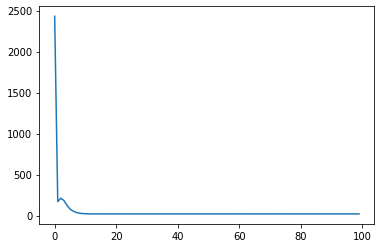

In [10]:
plt.plot(losses);

In [11]:
def generate_endmembers(vae_model, mean, var):
    z_sample = torch.normal(mean, var, size=(1, 2), dtype=torch.float).to(device)
    x_decoded = vae_model.decode(z_sample)
    endmember = x_decoded.detach().cpu().reshape(156, 3)
    for i in range(3):
        endmember[:, i] /= norm(endmember[:, i])
    plt.plot(endmember)
    plt.show()
    return endmember.numpy()

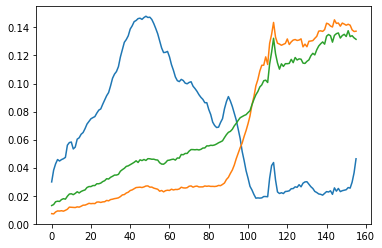

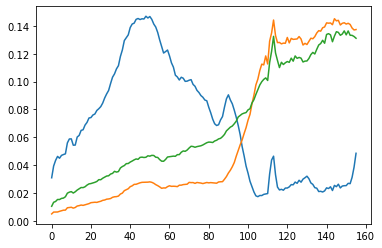

In [12]:
Ae1 = generate_endmembers(vae_model, 0, 3)
Ae2 = generate_endmembers(vae_model, 0, 3)

# Create Dataset for the main model

In [13]:
data_samson = sci.loadmat('../datasets/samson/samson_1.mat')
X_samson = data_samson['V']
X_samson = X_samson.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations
X_samson = X_samson.reshape(-1, nCol, nRow)

In [14]:
X_samson.shape

(156, 95, 95)

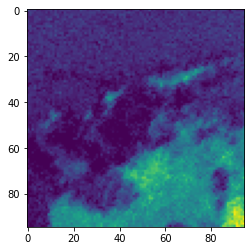

In [15]:
plt.imshow(X_samson[0, :, :,])

In [16]:
from src.data_processing import HyperspectralImage, OriginalImageDataset

samson = HyperspectralImage(image_path="../datasets/samson/samson_1.mat",
                           ground_truth_path="../datasets/samson/end3.mat",
                           n_bands=156, n_row=95, n_col=95, n_sources=3)

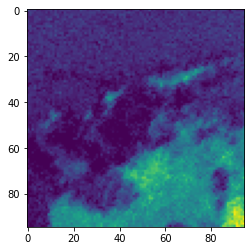

In [17]:
data_samson = sci.loadmat('../datasets/samson/samson_1.mat')
X_samson = data_samson['V']
X_samson = X_samson.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations
X_samson = X_samson.reshape(-1, nCol, nRow)
plt.imshow(X_samson[0, :, :])


In [18]:
# from src.data_processing import _create_patches
# from src.conf import PATCH_NUMBER, PATCH_SIZE
# from pysptools.abundance_maps import FCLS


# fcls = FCLS()

# generated_endmbs = [generate_endmembers(vae_model, 0, 3) for _ in range(100)]
# generated_abdns = [fcls.map(M=np.moveaxis(X_samson, 0, -1), U=generated_endmbs[i].astype(np.float64).reshape((3, 156)), 
#                             normalize=False, mask=None) for i in tqdm(range(len(generated_endmbs)))]


# created_images = [(generated_endmbs[i] @ generated_abdns[i].T.reshape(3, -1)).reshape(156,95,95).T + np.random.normal(0, 0.0005, (95,95,156))
#                   for i in tqdm(range(len(generated_endmbs)))]

# for i in tqdm(range(len(generated_endmbs))):

#     X_patches, _, S_patches = _create_patches(samson, np.moveaxis(created_images[i], -1, 0), generated_endmbs[i], 
#                                               np.moveaxis(generated_abdns[i], -1, 0),
#                                               patch_size=(PATCH_SIZE, PATCH_SIZE), max_patches=PATCH_NUMBER,
#                                               is_pixel_wise=False)
#     # SAVE OBTAINED PATCHES TO FILE
#     # Save 100+100+100 patches for each image
#     # Later, when accessing, you can go through random indices
#     for j, (pX, pS) in tqdm(enumerate(zip(X_patches, S_patches))):
#         name_file_X = f'temp_data/vae_patches/im_{i * PATCH_NUMBER + j}_X.npy'
#         name_file_A = f'temp_data/vae_patches/im_{i * PATCH_NUMBER + j}_A.npy'
#         name_file_S = f'temp_data/vae_patches/im_{i * PATCH_NUMBER + j}_S.npy'

#         # Save data using NumPy's np.save
#         np.save(name_file_X, pX)
#         np.save(name_file_A, generated_endmbs[i])
#         np.save(name_file_S, pS)

In [19]:
sv_X_patch = np.load(f'../patches_for_training/vae_patches/im_10_X.npy')
sv_A_patch = np.load(f'../patches_for_training/vae_patches/im_10_A.npy')
sv_S_patch = np.load(f'../patches_for_training/vae_patches/im_10_S.npy')

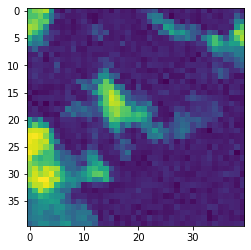

In [20]:
plt.imshow(sv_X_patch[0, :, :])

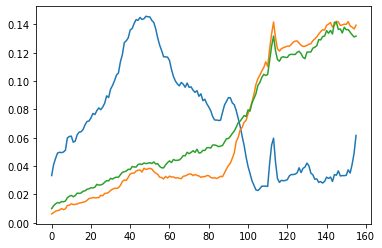

In [21]:
plt.plot(sv_A_patch)

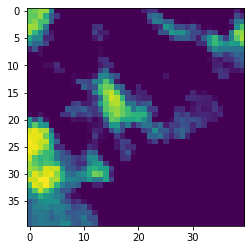

In [22]:
plt.imshow(sv_S_patch[0, :, :])

In [23]:
class PerturbedSimpleDataPatches(torch.utils.data.Dataset):
    def __init__(self):
        self.N_train = 100
        self.patch_size = (40, 40)
        self.max_patches = 50

    def __len__(self):
        return self.N_train * self.max_patches

    def __getitem__(self, idx):
        name_file_X = f'../patches_for_training/vae_patches/im_{idx}_X.npy'
        name_file_A = f'../patches_for_training/vae_patches/im_{idx}_A.npy'
        name_file_S = f'../patches_for_training/vae_patches/im_{idx}_S.npy'

        sv_X_patch = np.load(name_file_X)
        sv_A_patch = np.load(name_file_A)
        sv_S_patch = np.load(name_file_S)

        return {
            'X': torch.Tensor(sv_X_patch),
            'A': torch.Tensor(sv_A_patch),
            'S': torch.Tensor(sv_S_patch)
        }

In [24]:
vae_image_dataset = PerturbedSimpleDataPatches()

In [25]:
len(vae_image_dataset)

5000

original_image_dataloader torch.Size([10, 156, 40, 40])


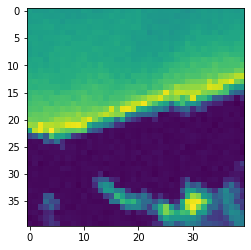

In [26]:
from src.conf import BATCH_SIZE

vae_image_dataloader = DataLoader(dataset=vae_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
a = next(iter(vae_image_dataloader))
print('original_image_dataloader', a["X"].shape)
plt.imshow(a['X'][0][50])
plt.show()

In [27]:
len(vae_image_dataset)

5000

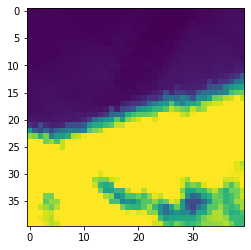

In [28]:
plt.imshow(a['S'][0][2])

TRAINING WILL BE DONE ON cpu
 Epoch 1/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


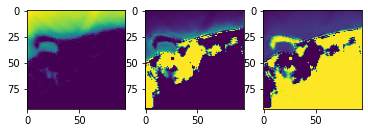

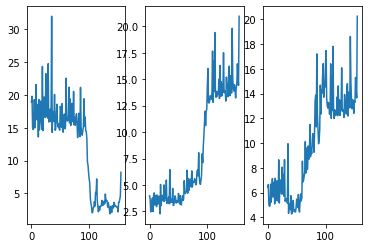

Loss: 0.3646
 Epoch 2/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:59<00:00,  2.79it/s]


Loss: 0.1850
 Epoch 3/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1753
 Epoch 4/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1743
 Epoch 5/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:57<00:00,  2.81it/s]


Loss: 0.1736
 Epoch 6/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


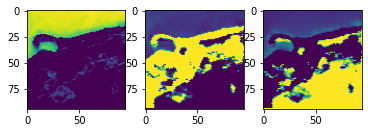

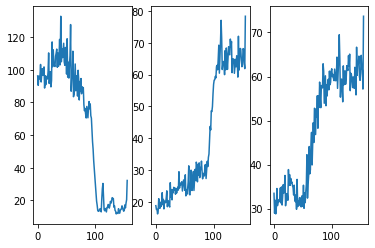

Loss: 0.1737
 Epoch 7/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1652
 Epoch 8/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1579
 Epoch 9/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1586
 Epoch 10/50
----------------------------------------
Learning rate: 0.01


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1640
 Epoch 11/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:58<00:00,  2.80it/s]


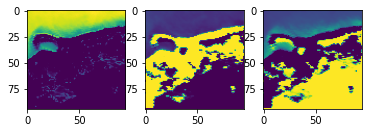

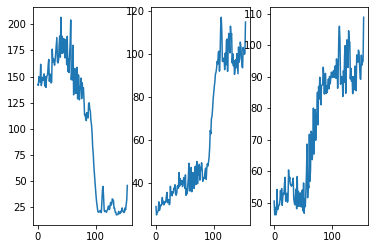

Loss: 0.1476
 Epoch 12/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1629
 Epoch 13/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1572
 Epoch 14/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1571
 Epoch 15/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Loss: 0.1655
 Epoch 16/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


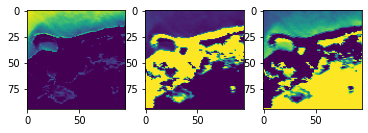

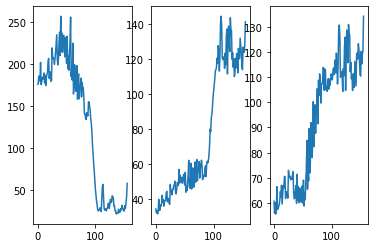

Loss: 0.1657
 Epoch 17/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1619
 Epoch 18/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1607
 Epoch 19/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.86it/s]


Loss: 0.1557
 Epoch 20/50
----------------------------------------
Learning rate: 0.0095


100%|█████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


Loss: 0.1528
 Epoch 21/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


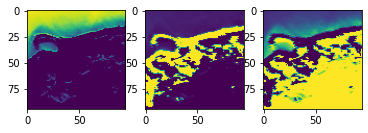

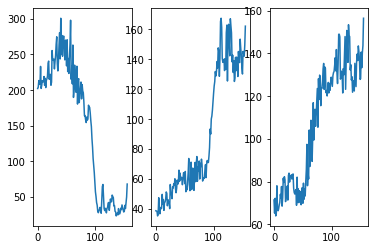

Loss: 0.1502
 Epoch 22/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


Loss: 0.1565
 Epoch 23/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


Loss: 0.1574
 Epoch 24/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


Loss: 0.1618
 Epoch 25/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1500
 Epoch 26/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


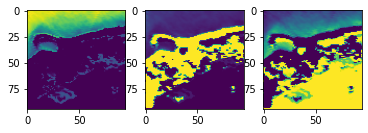

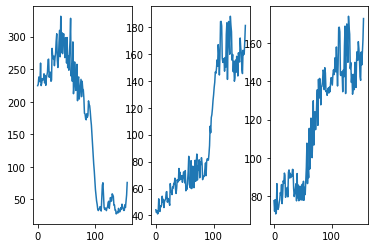

Loss: 0.1618
 Epoch 27/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1523
 Epoch 28/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1572
 Epoch 29/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1580
 Epoch 30/50
----------------------------------------
Learning rate: 0.009025


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1546
 Epoch 31/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


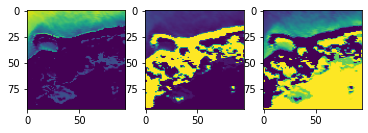

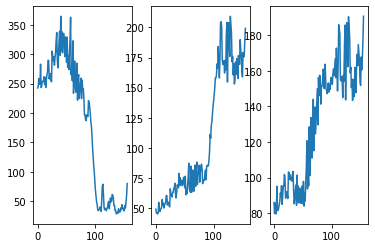

Loss: 0.1489
 Epoch 32/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Loss: 0.1498
 Epoch 33/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1536
 Epoch 34/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1551
 Epoch 35/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1552
 Epoch 36/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


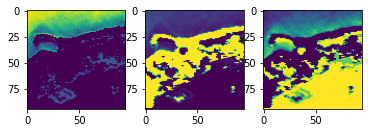

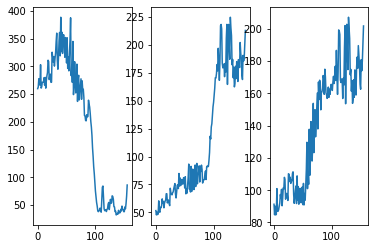

Loss: 0.1544
 Epoch 37/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1599
 Epoch 38/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1546
 Epoch 39/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1570
 Epoch 40/50
----------------------------------------
Learning rate: 0.00857375


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1556
 Epoch 41/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


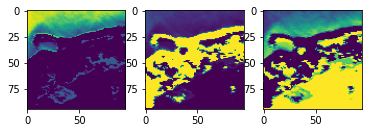

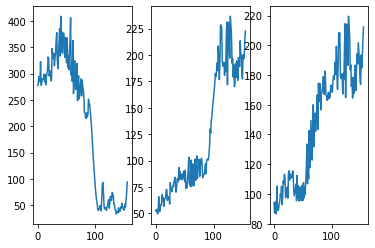

Loss: 0.1617
 Epoch 42/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1655
 Epoch 43/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Loss: 0.1535
 Epoch 44/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [02:55<00:00,  2.84it/s]


Loss: 0.1654
 Epoch 45/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [02:58<00:00,  2.81it/s]


Loss: 0.1608
 Epoch 46/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [04:55<00:00,  1.69it/s]


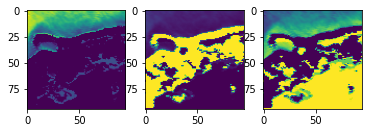

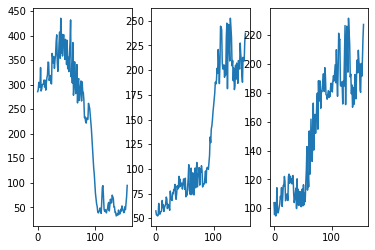

Loss: 0.1522
 Epoch 47/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [06:20<00:00,  1.31it/s]


Loss: 0.1483
 Epoch 48/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [05:26<00:00,  1.53it/s]


Loss: 0.1484
 Epoch 49/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [06:13<00:00,  1.34it/s]


Loss: 0.1549
 Epoch 50/50
----------------------------------------
Learning rate: 0.0081450625


100%|█████████████████████████████████████████| 500/500 [07:01<00:00,  1.19it/s]

Loss: 0.1455


In [29]:
from src.train_utils import train_model
from src.loss_functions import balance_loss
from src.models import Autoencoder

model = Autoencoder(channel_number=samson.n_bands, source_number=samson.n_sources)
model, loss_train = train_model(model, samson.X,
                                      vae_image_dataloader,
                                      balance_loss, num_epochs=50, n_sources=3, need_plot=True)

compare_endmembers 0.9454008819385141


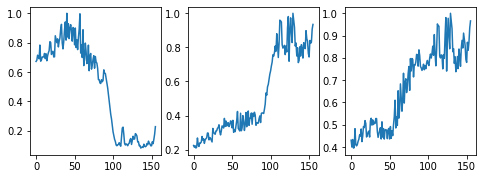

compare_abundances 0.1763964279201128


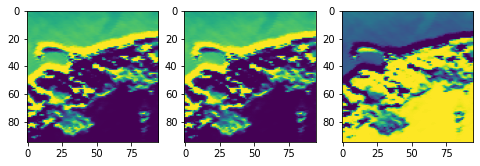

In [30]:
from src.metrics import compare_abundances, compare_endmembers

torch.save(model.state_dict(), "../results/models_weights/samson_vae_balance_loss_0.pth")

X, A, S = model(torch.Tensor(samson.X[None, :, :, :]))
X, A, S = X.detach().numpy()[0], A.detach().numpy(), S.detach().numpy()[0]
# Endmembers normalization
for i in range(A.shape[1]):
        M = A[:, i].max().item()
        A[:, i] = A[:, i]/M
                      
print('compare_endmembers', compare_endmembers(samson, A, metric="cos_sim"))
plt.figure(figsize=(8,6))
for ii in range(3): 
    ax = plt.subplot(2, 3, ii+1)
    ax.plot(A[:,ii])
plt.show()
                
print('compare_abundances', compare_abundances(samson, S))
plt.figure(figsize=(8,6))
for ii in range(3): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S[ii, :, :])  
plt.show()
